In [1]:
# GET PARAMETERS
import os 
import sys
import pandas as pd
import torch 
import pickle
import numpy as np 
import importlib
import pickle
if torch.cuda.is_available():
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32  = True

# Get Parent folder : 
current_path = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_path, '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)


# Personnal imports: 
from constants.paths import SAVE_DIRECTORY, FOLDER_PATH
from examples.accuracy_comparison import load_trainer_ds_from_saved_trial

/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


No module xgboost
Training and Hyper-parameter tuning with Ray is not possible
Training and Hyper-parameter tuning with Ray is not possible



## Load trained model, without the use of NetMob: 

In [2]:
subfolder = 'K_fold_validation/training_wo_HP_tuning/optim/subway_in_STGCN'
path_model_args = f"../{SAVE_DIRECTORY}/{subfolder}/best_models"
model_args = pickle.load(open(f"{path_model_args}/model_args.pkl", 'rb'))


# trial_id1 = 'subway_in_calendar_emb64_out64_Huber_MinMax_bis1'   
# trial_id1 = 'subway_in_calendar_emb64_out64_Huber_MinMax_horizon1_bis1'
# trial_id1 = 'subway_in_calendar_emb64_out64_Huber_MinMax_horizon2_bis1'
# trial_id1 = 'subway_in_calendar_emb64_out64_Huber_MinMax_horizon3_bis1'
# trial_id1 = 'subway_in_calendar_emb64_out64_Huber_MinMax_horizon4_bis1'

# Load Model from trial : 
trial_id = 'subway_in_calendar_emb64_out64_Huber_MinMax_horizon1_bis1'

trial_id_updated = f"_{trial_id}_f5"
args = model_args['model'][trial_id_updated]['args']
model_save_path = f"{path_model_args}/{trial_id_updated}.pkl"
trained_trainer, trained_ds, trained_args = load_trainer_ds_from_saved_trial(args,model_save_path,modification = {('device'): torch.device('cuda:0')})

----------------------------------------
Loading the Complete Dataset for K-fold splitting
Coverage Period: 7392 elts between 2019-03-16 00:00:00 and 2019-05-31 23:45:00
Invalid dates within this fold: 776

>>>Tackle Target dataset: subway_in
   Load data from: //home/rrochas/../../data/rrochas/prediction_validation/subway_in/subway_in.csv
   Init Dataset: 'torch.Size([7392, 40]). 0 Nan values
   TRAIN contextual_ds: torch.Size([2821, 40, 7])
   VALID contextual_ds: torch.Size([940, 40, 7])
   TEST contextual_ds: torch.Size([940, 40, 7])

>>>Loading calendar embedding inputs ...
    dict_keys(['dayofweek_OHE', 'hour_OHE'])
   args_embedding.variable_selection_model_name:  MLP
Init U/Utarget size: torch.Size([4702, 40, 7])/torch.Size([4702, 40, 1]) Train/Valid/Test 2821 940 940

 ===== ERROR WITH prefetch_factor====  
ValueError: prefetch_factor option could only be specified in multiprocessing.let num_workers > 0 to enable multiprocessing

----------------------------------------
Loadi

## Load a New Trainer, with NetMob Inputs : 

In [18]:
from examples.train_model import load_init_model_trainer_ds
from examples.benchmark import local_get_args
from examples.reproductibility.config_STGCN_Subway_in_NetMob_calendar_h1 import modifications

modification = modifications['HPO_subway_in_calendar_embedding_netmob_POIs_STGCN_HuberLossLoss_2025_08_11_23_22_40073_h1']
modification['torch_compile'] = False # 'compile'
modification['contextual_kwargs']['netmob_POIs']['agg_iris_target_n'] = 50
modification['contextual_kwargs']['netmob_POIs']['attn_kwargs']['dim_feedforward'] = 256 # 128 
modification['contextual_kwargs']['netmob_POIs']['attn_kwargs']['num_heads'] = 2 # 4
modification['contextual_kwargs']['netmob_POIs']['attn_kwargs']['nb_layers'] = 3 #3
modification['contextual_kwargs']['netmob_POIs']['attn_kwargs']['dim_model'] = 128 #64
modification['contextual_kwargs']['netmob_POIs']['attn_kwargs']['keep_topk'] = 30 #30     choices: [False, 10, 20, 30]
modification['contextual_kwargs']['netmob_POIs']['attn_kwargs']['latent_dim'] = 128 # Output dimension after last FC layer before concatenation late.
modification['contextual_kwargs']['netmob_POIs']['NetMob_selected_apps'] = ['Web_Weather'] #['Google_Maps', 'Web_Weather']

save_folder = None

args_init = local_get_args(modification['model_name'],
                args_init = None,
                dataset_names=modification['dataset_names'],
                dataset_for_coverage=modification['dataset_for_coverage'],
                modification = modification)
fold_to_evaluate=[args_init.K_fold-1]

trainer,ds,model,args = load_init_model_trainer_ds(fold_to_evaluate,save_folder,args_init,modification,trial_id)

----------------------------------------
Loading the Complete Dataset for K-fold splitting
Coverage Period: 7392 elts between 2019-03-16 00:00:00 and 2019-05-31 23:45:00
Invalid dates within this fold: 776

>>>Tackle Target dataset: subway_in
   Load data from: //home/rrochas/../../data/rrochas/prediction_validation/subway_in/subway_in.csv
   Init Dataset: 'torch.Size([7392, 40]). 0 Nan values
   TRAIN contextual_ds: torch.Size([2821, 40, 7])
   VALID contextual_ds: torch.Size([940, 40, 7])
   TEST contextual_ds: torch.Size([940, 40, 7])

>>>Loading calendar embedding inputs ...
    dict_keys(['dayofweek_OHE', 'hour_OHE'])
   args_embedding.variable_selection_model_name:  MLP

>>>Tackle Contextual dataset:  netmob_POIs
    ATTENTION: Dimension reduction by clustering is applied on the entire dataset. This should be done only on the training set.
    Netmob_T.size(): torch.Size([7392, 49]). Dimensionality reduced by 2.0%


Restraining all datasets to train common dates: 2821 dates
Restr

## Transfer Learning: 

In [19]:
# Option 1: Transférer tous les poids possibles et les geler
print("--- Transferring all possible weights ---")
trainer.transfer_weights_from(trained_trainer, freeze_transferred=True, List_not_freezing = ['core_model.output'])

# Option 2: Transférer uniquement les modules 'te' et 'core_model' et les geler
# print("\n\n--- Transferring specific modules ('te' and 'core_model') ---")
# modules_to_transfer = ['te', 'core_model']
# trainer.transfer_weights_from(trained_trainer, modules_to_transfer=modules_to_transfer, freeze_transferred=True,List_not_freezing = ['core_model.output'])

--- Transferring all possible weights ---
62 layers have been frozen.

--- Transfer Summary ---
Kept 41 layers to train.
Found 1 layers with mismatched shapes (weights not transferred):
  - core_model.output.fc1.weight: Dest: torch.Size([64, 256]) vs Source: torch.Size([64, 128])
------------------------

Model structure after transfer:

- Blue:  All parameters in the module were transferred AND are frozen
 - Green:  All parameters in the module were transferred AND are NOT frozen
 - Yellow: Some, but not all, parameters were transferred
 - White: No parameters were transferred

(spatial_attn_per_station): ModuleDict()
(spatial_attn_poi): ModuleDict(
spatial_attn_poi.(netmob_POIs): model(
spatial_attn_poi.netmob_POIs.(mha_list): ModuleList(
spatial_attn_poi.netmob_POIs.mha_list.(0): MHA_layer(
spatial_attn_poi.netmob_POIs.mha_list.0.(mha): MultiHeadAttention(
spatial_attn_poi.netmob_POIs.mha_list.0.mha.(softmax): Softmax(dim=-1)
spatial_attn_poi.netmob_POIs.mha_list.0.mha.(dropout): Dr

## Train Spatial Attention Module : 

In [20]:
print('number of total parameters: {}'.format(sum([p.numel() for p in trainer.model.parameters()])))
print('number of trainable parameters: {}'.format(sum([p.numel() for p in trainer.model.parameters() if p.requires_grad])))

number of total parameters: 1293132
number of trainable parameters: 384861


In [21]:
trainer.args.epochs = 150
trainer.train_and_valid()


start training
Epoch: 1     Train Loss: 0.0114368115540545 Val Loss: 0.0024545808828019713
epoch: 1 
 min\epoch : 0.04
Estimated time for training: 5.0min 
Epoch: 3     Train Loss: 0.002422944862806218 Val Loss: 0.0017311765470522198
Epoch: 17     Train Loss: 0.0014014474270358228 Val Loss: 0.001250033252228527
Epoch: 34     Train Loss: 0.0012573432280886384 Val Loss: 0.0011805236609553561
Epoch: 51     Train Loss: 0.0012067114425168097 Val Loss: 0.001180954351079987
Epoch: 67     Train Loss: 0.0011819145246961863 Val Loss: 0.001154079880723928
Epoch: 84     Train Loss: 0.00114551742792424 Val Loss: 0.0011556147847899257
Epoch: 101     Train Loss: 0.0011306341879633683 Val Loss: 0.0011490847454703552
Epoch: 117     Train Loss: 0.0011165098584022173 Val Loss: 0.0011513227591925161
Epoch: 134     Train Loss: 0.0011049779367232706 Val Loss: 0.0011558628125869213
Epoch: 150     Train Loss: 0.0010935688796656214 Val Loss: 0.001153876553933592

Training Throughput:2871.39 sequences per seco

## Analysing Training : 

In [22]:
from examples.train_and_visu_non_recurrent import get_df_for_visualisation,visualisation_special_event
training_mode = 'test'
station=['BEL']
Preds,Y_true,T_labels = trainer.testing(ds.normalizer, training_mode =training_mode)   
df_true,df_predictions = get_df_for_visualisation(ds,Preds,Y_true,training_mode,trainer.out_dim_factor,stations=station)
visualisation_special_event(trainer,df_true,df_predictions,station=station,min_flow=0)

print('MAE: ',torch.abs(Y_true-Preds).mean().item(),'\n',
      'RMSE: ', np.sqrt(((Y_true-Preds)**2).mean().item()),'\n',
      'MSE: ', ((Y_true-Preds)**2).mean().item(),'\n'
)

Loading BokehJS ...

MAE:  20.20749282836914 
 RMSE:  35.654986694316335 
 MSE:  1271.278076171875 



## Analysing Attention Weight : 

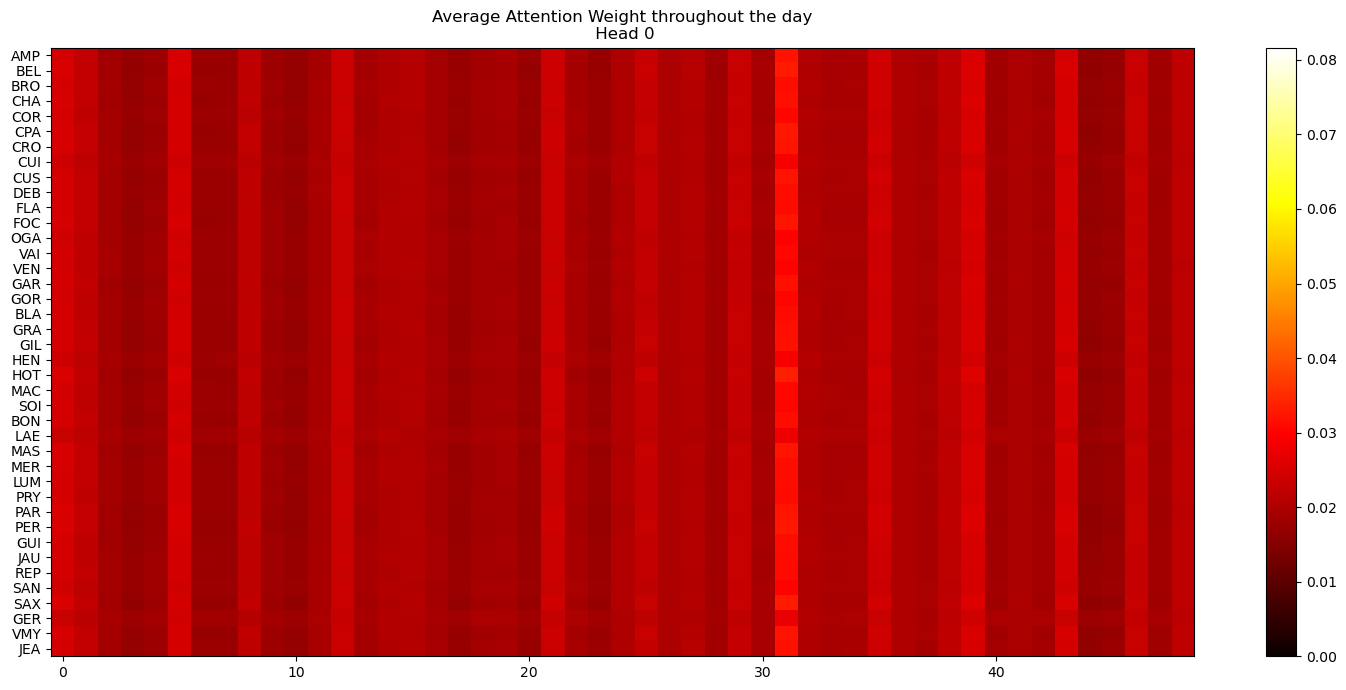

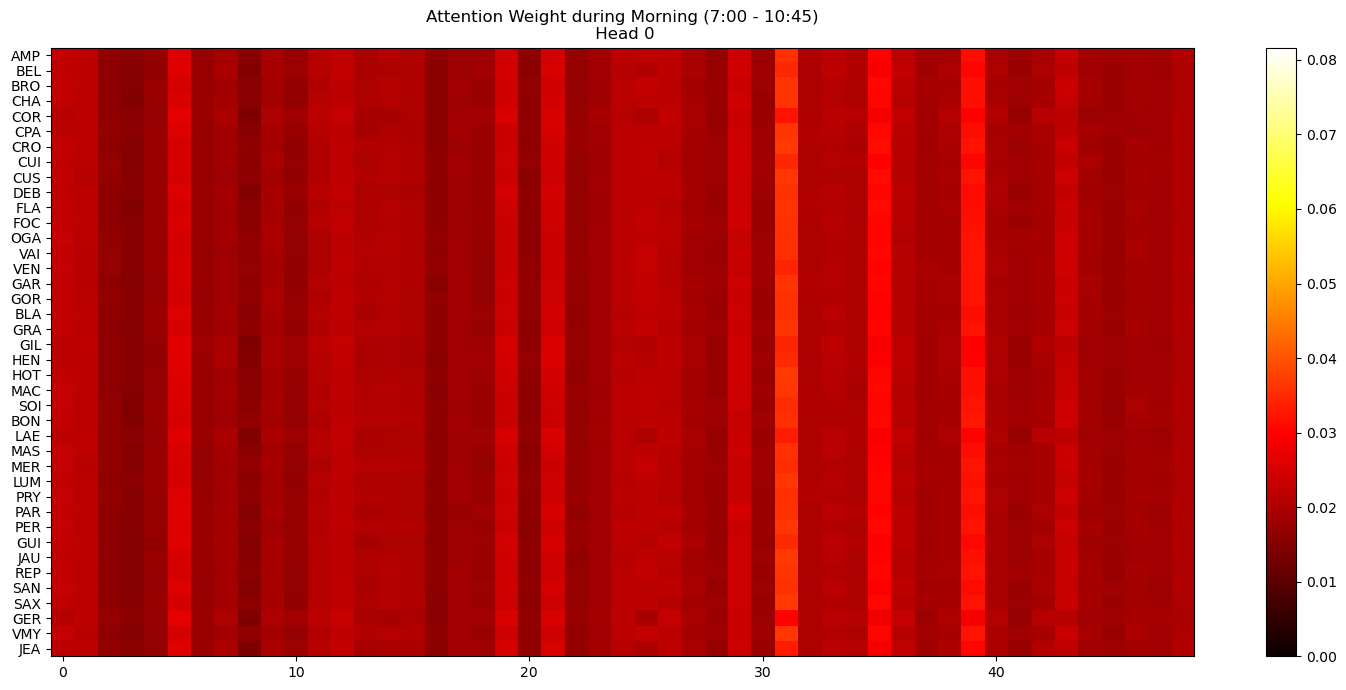

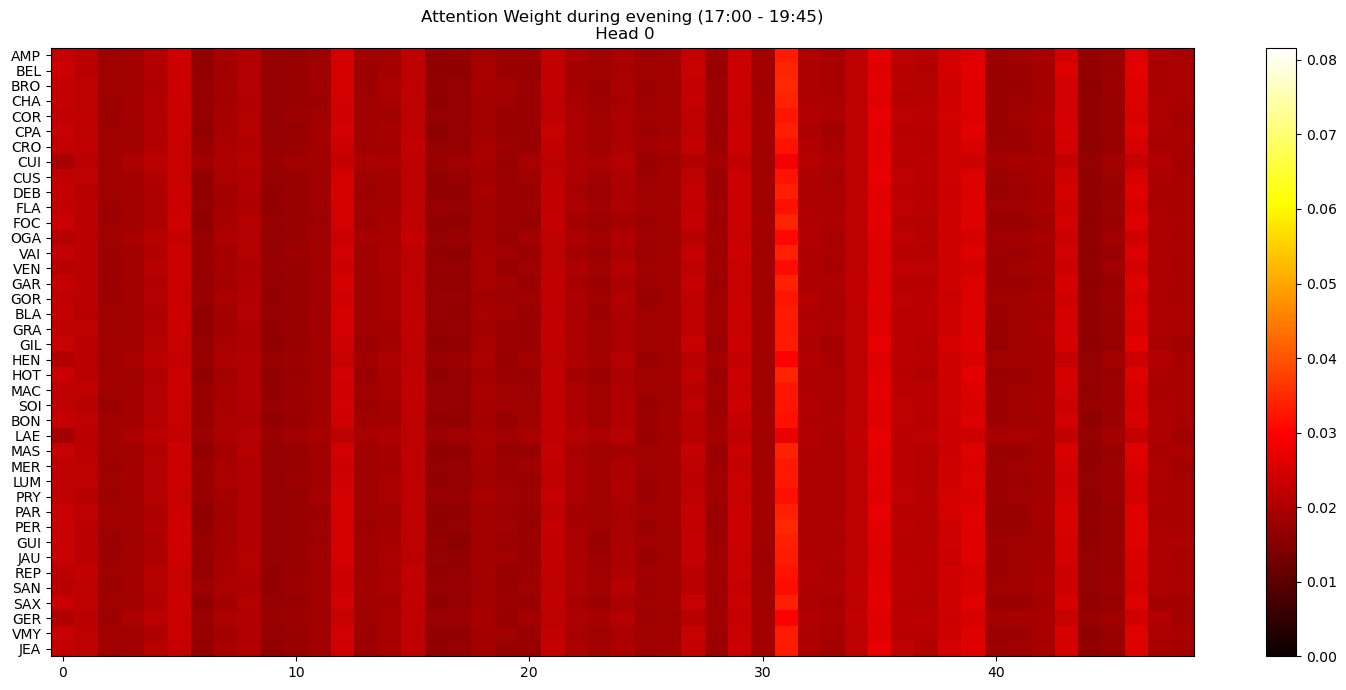

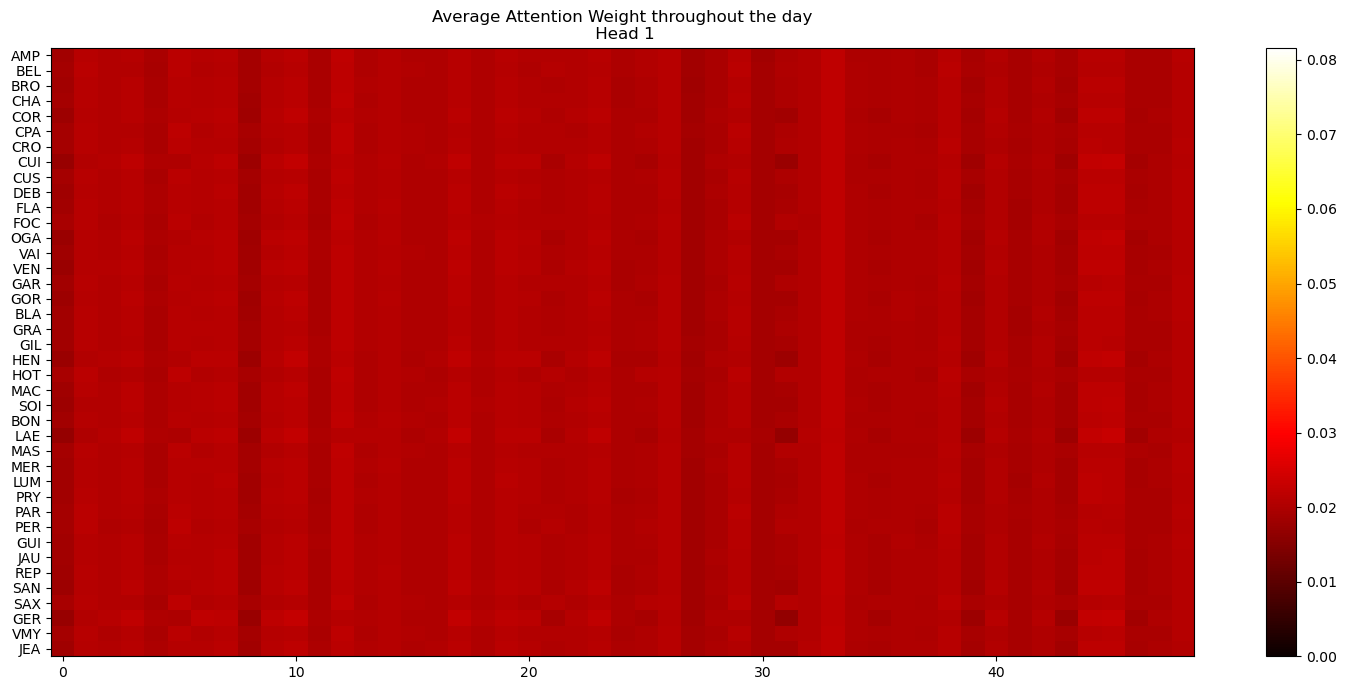

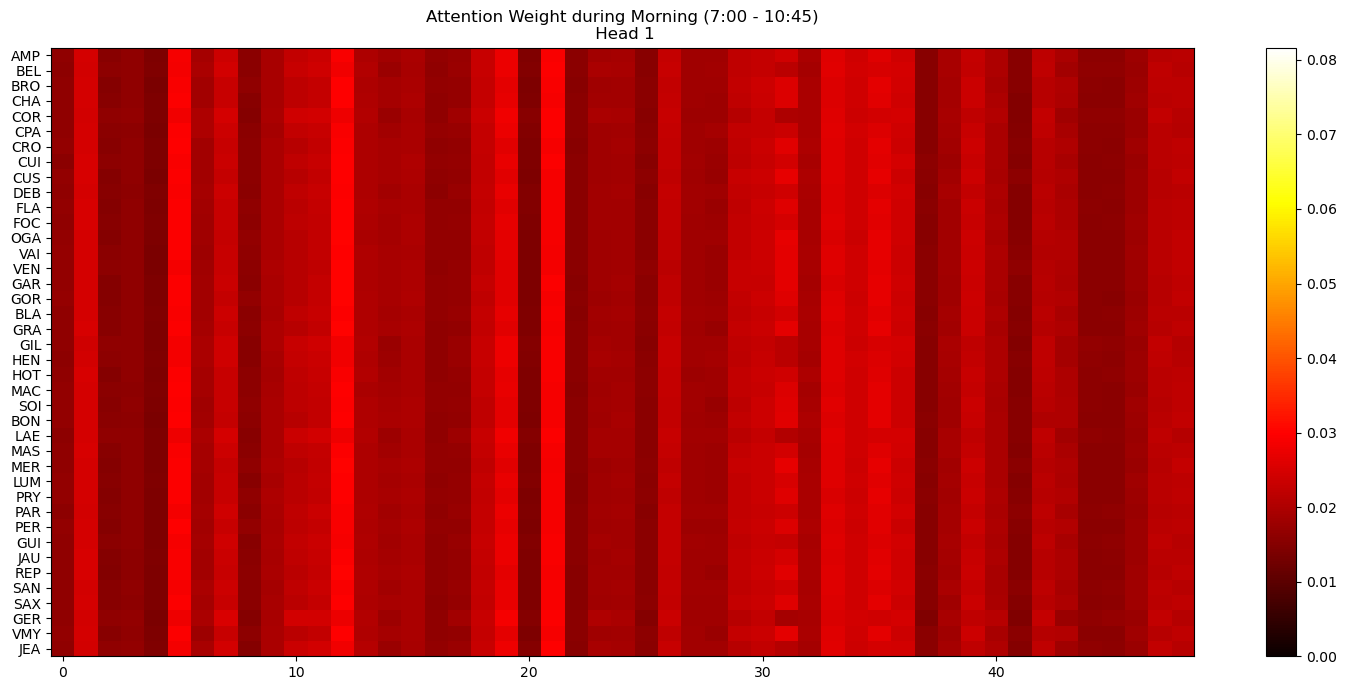

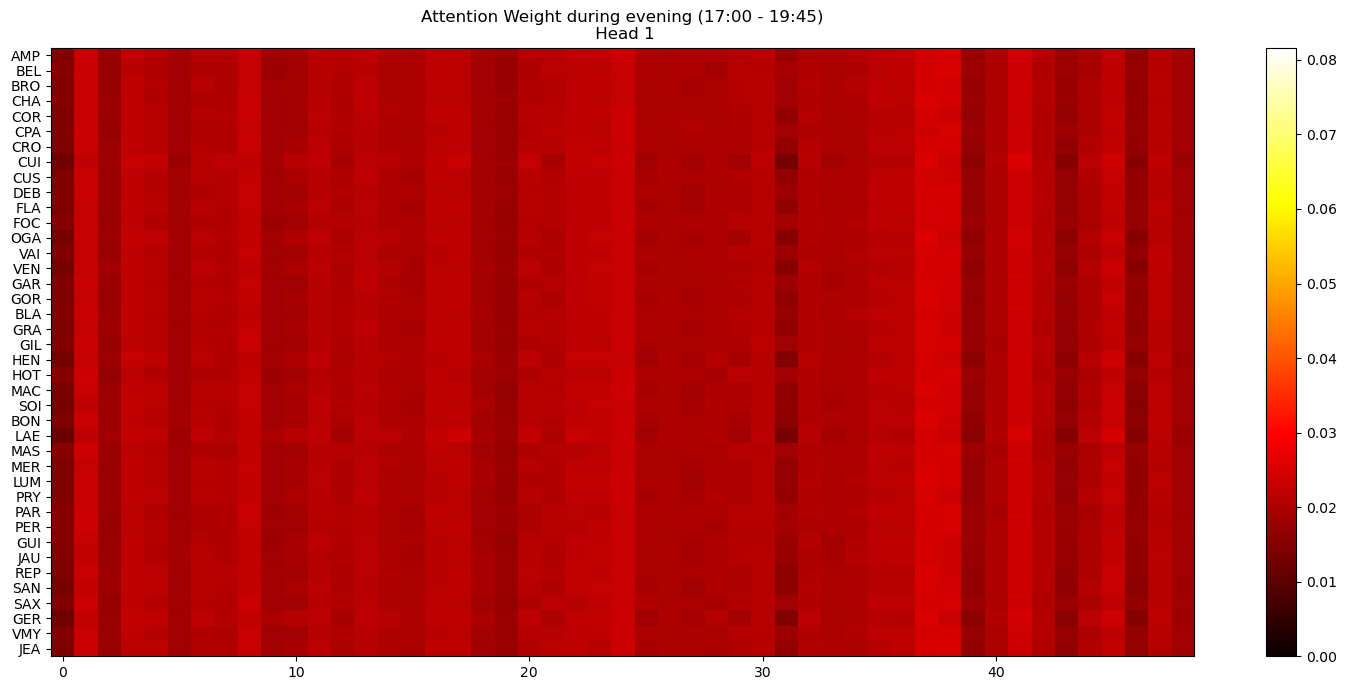

In [23]:
from examples.accuracy_comparison import plot_attn_weights
vmax_coeff = 4
# ---- Plot Attention Weights ---- 
if hasattr(args,'contextual_kwargs') and len(args.contextual_kwargs) > 0:
    contextual_datasets = list(args.contextual_kwargs.keys())
    for contextual_dataset in contextual_datasets:
        X = torch.cat([x for x,y,x_c  in trainer.dataloader['test']]).to(args.device)
        Y = torch.cat([y for x,y,x_c  in trainer.dataloader['test']]).to(args.device)
        nb_contextual = len(next(iter(trainer.dataloader['train']))[2])
        Xc = [torch.cat([x_c[r] for x,y,x_c  in trainer.dataloader['test']]).to(args.device) for r in range(nb_contextual)]
        model = trainer.model
        model.eval()
        with torch.no_grad():
            pred = model(X,Xc)
        try: 
            NetMob_attn_weights = getattr(trainer.model.spatial_attn_poi,contextual_dataset).attn_weight
        except:
            try: 
                NetMob_attn_weights = getattr(trainer.model.core_model.output.ModuleContextualAttnLate,contextual_dataset).attn_weight
            except:
                NetMob_attn_weights = getattr(trainer.model.spatial_attn_poi,contextual_dataset).mha_list[-1].attn_weight


        s_dates = ds.tensor_limits_keeper.df_verif_test.iloc[:,-1].reset_index(drop=True)
        plot_attn_weights(NetMob_attn_weights,s_dates,
                        #   weekdays,hours,
                        ds.spatial_unit,
                        vmax_coeff = vmax_coeff)

In [24]:
import geopandas as gpd 
from examples.accuracy_comparison import get_calendar_mask
from plotting.plotting import set_attention_weights_agregated_per_daily_period
from plotting.plotting_folium import plot_folium_map

# ---- Load gdf ----
# Find correspondence between attn weights and concerned netmob zones/apps:
for contextual_dataset in contextual_datasets:
    list_correspondence = args.contextual_kwargs[contextual_dataset]['list_correspondence']
    dictionnary_aggregated_iris = args.contextual_kwargs[contextual_dataset]['dictionnary_aggregated_iris']
    dict_label2agg = args.contextual_kwargs[contextual_dataset]['dict_label2agg']

    dict_agg2label = {}
    for k,v in dict_label2agg.items():
        if v not in dict_agg2label:
            dict_agg2label[v] = []
        dict_agg2label[v].append(k)


    # Load gdf : 
    agg_iris_target_n = args.contextual_kwargs[contextual_dataset]['agg_iris_target_n']
    if agg_iris_target_n is not None: 
        gdf = gpd.read_file(f"{FOLDER_PATH}/lyon_iris_agg{agg_iris_target_n}")
    else:
        gdf = gpd.read_file(f"{FOLDER_PATH}/lyon_iris_shapefile")
    # ----


    # ---- Set Parameter for the map visualization ----
    station = 'CHA' # HOT: 'hotel de ville'

    station_i = list(ds.spatial_unit).index(station)
    head = 0
    for head in range(NetMob_attn_weights.size(1)):
        for temporal_group in ['evening_peak','morning_peak']:
            mask = get_calendar_mask(s_dates,temporal_group = temporal_group,city=None)   # mask_morning  # mask_evening # mask_off_peak # mask_7 # # mask_8 # mask_9 # mask_16 # mask_17 # mask_18 # mask_21 # mask_22 # mask_23
            # Time Slot 0, Head 0, Station 0:
            uniform_weights = 1/NetMob_attn_weights.size(-1)
            VMIN = 0.5*uniform_weights
            VMAX = vmax_coeff*uniform_weights #2*uniform_weights
            CMAP = 'OrRd'

            print('Size of NetMob_attn_weights: ',NetMob_attn_weights.size())
            print('Uniform weights: ', uniform_weights, 'Vmin: ',VMIN, 'Vmax: ',VMAX)   

            globals()[f"gdf_copy_{temporal_group}"] = set_attention_weights_agregated_per_daily_period(gdf,NetMob_attn_weights, 
                                                                station_i,head, mask, agg_iris_target_n,
                                                                dict_agg2label,list_correspondence)

            for app_tag_mode in ['Google_Maps_iris_DL','Web_Weather_iris_DL']:
                try: 
                    print(f"Plotting Attention Weights at HEAD {head} for {app_tag_mode} at {station} ({temporal_group})") 
                    m_google_maps =plot_folium_map(FOLDER_PATH, globals()[f"gdf_copy_{temporal_group}"], app_tag_mode=app_tag_mode,
                                            spatial_unit = list(ds.spatial_unit), station_i=station_i, VMIN=VMIN, VMAX=VMAX)
                    display(m_google_maps)
                except:
                    print("no ",app_tag_mode)

Size of NetMob_attn_weights:  torch.Size([940, 2, 40, 49])
Uniform weights:  0.02040816326530612 Vmin:  0.01020408163265306 Vmax:  0.08163265306122448
Plotting Attention Weights at HEAD 0 for Google_Maps_iris_DL at CHA (evening_peak)
no  Google_Maps_iris_DL
Plotting Attention Weights at HEAD 0 for Web_Weather_iris_DL at CHA (evening_peak)


Size of NetMob_attn_weights:  torch.Size([940, 2, 40, 49])
Uniform weights:  0.02040816326530612 Vmin:  0.01020408163265306 Vmax:  0.08163265306122448
Plotting Attention Weights at HEAD 0 for Google_Maps_iris_DL at CHA (morning_peak)
no  Google_Maps_iris_DL
Plotting Attention Weights at HEAD 0 for Web_Weather_iris_DL at CHA (morning_peak)


Size of NetMob_attn_weights:  torch.Size([940, 2, 40, 49])
Uniform weights:  0.02040816326530612 Vmin:  0.01020408163265306 Vmax:  0.08163265306122448
Plotting Attention Weights at HEAD 1 for Google_Maps_iris_DL at CHA (evening_peak)
no  Google_Maps_iris_DL
Plotting Attention Weights at HEAD 1 for Web_Weather_iris_DL at CHA (evening_peak)


Size of NetMob_attn_weights:  torch.Size([940, 2, 40, 49])
Uniform weights:  0.02040816326530612 Vmin:  0.01020408163265306 Vmax:  0.08163265306122448
Plotting Attention Weights at HEAD 1 for Google_Maps_iris_DL at CHA (morning_peak)
no  Google_Maps_iris_DL
Plotting Attention Weights at HEAD 1 for Web_Weather_iris_DL at CHA (morning_peak)
